https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet

In [ ]:
#pip install remotezip tqdm opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52 tf-models-official

  Using cached remotezip-0.12.3-py3-none-any.whl (8.1 kB)
ERROR: Could not find a version that satisfies the requirement opencv-python==4.5.2.52 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84)
ERROR: No matching distribution found for opencv-python==4.5.2.52


In [27]:
pip install tf-models-official

Good article on memory optimization
https://towardsdatascience.com/optimize-memory-tips-in-python-3bbb44512937

In [28]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2 as cv
import pandas as pd
import os
import numpy as np
#import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

#import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print("gpu")
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

gpu


### Data set preparation and pre-processing

In [6]:
main_path = "/content/drive/MyDrive/Multi Class Dataset"
csv_path = "/content/drive/MyDrive/Codes/CSVs/1_Second_method_for_multiple_classes"
dataset_path = os.listdir(main_path)

train_bin=[]
test_bin=[]
for item in dataset_path:
    all_vids = os.listdir(main_path+"/"+ item)
    bin=[]
    for vid in all_vids:
        path = os.path.join(main_path+"/"+item+"/"+vid)
        if os.path.exists(path):  # Here we are selecting only the valid paths
            bin.append((str(main_path+"/"+item)+"/"+vid,item))

    l=int(len(bin)*0.8)
    train_bin.extend(bin[:l])
    test_bin.extend(bin[l:])

df_train = pd.DataFrame(data= train_bin,columns=['Name','tag'])
print(f"Train set size = {len(df_train)}")
#df_train = df_train.sample(frac=1)
print(df_train.head())
df_test = pd.DataFrame(data= test_bin,columns=['Name','tag'])
print(f"Test set size = {len(df_test)}")
#df_test = df_test.sample(frac=1)
print(df_test.head())


Train set size = 1726
                                                Name    tag
0  /content/drive/MyDrive/Multi Class Dataset/Abu...  Abuse
1  /content/drive/MyDrive/Multi Class Dataset/Abu...  Abuse
2  /content/drive/MyDrive/Multi Class Dataset/Abu...  Abuse
3  /content/drive/MyDrive/Multi Class Dataset/Abu...  Abuse
4  /content/drive/MyDrive/Multi Class Dataset/Abu...  Abuse
Test set size = 435
                                                Name    tag
0  /content/drive/MyDrive/Multi Class Dataset/Abu...  Abuse
1  /content/drive/MyDrive/Multi Class Dataset/Abu...  Abuse
2  /content/drive/MyDrive/Multi Class Dataset/Abu...  Abuse
3  /content/drive/MyDrive/Multi Class Dataset/Abu...  Abuse
4  /content/drive/MyDrive/Multi Class Dataset/Abu...  Abuse


In [7]:
# upsampling

from sklearn.utils import resample

def upsample(data_frame):
    val_counts =data_frame['tag'].value_counts()
    max_category_size = np.max(val_counts)
    upsampled_full_df=[]
    for category, subset_df in data_frame.groupby('tag'):
        if val_counts[category] < max_category_size:
            subset_df = resample(subset_df,
                                    replace=True,                    # Sample with replacement
                                    n_samples=max_category_size,     # Majority class size
                                    random_state=42)
        upsampled_full_df.append(subset_df)
    return pd.concat(upsampled_full_df).reset_index(drop=True)

upsampled_train_df = upsample(df_train)
upsampled_test_df = upsample(df_test)
# Shuffel the dataset
upsampled_train_df = upsampled_train_df.sample(frac = 1).reset_index(drop=True)
upsampled_test_df = upsampled_test_df.sample(frac = 1).reset_index(drop=True)

print(df_train['tag'].value_counts())
print(df_test['tag'].value_counts())
print(f"Before upsampling train :- {df_train.shape}")
print(f"Before upsampling test :- {df_test.shape}")
print(f"After upsampling train :- {upsampled_train_df.shape}")
print(f"After upsampling test :- {upsampled_test_df.shape}")
print(upsampled_train_df['tag'].value_counts())
print(upsampled_test_df['tag'].value_counts())

# Saving data set info to csv
df_train= upsampled_train_df.loc[:,['Name','tag']] #df_train.loc[:,['Name','tag']]
df_train.to_csv(os.path.join(csv_path,'train_upsampled.csv'))
df_test=upsampled_test_df.loc[:,['Name','tag']]
df_test.to_csv(os.path.join(csv_path,'test_upsampled.csv'))


tag
Fighting        443
Nonviolence     388
Shooting        327
Abuse           180
Car Accident    164
Explosion       138
Riot             86
Name: count, dtype: int64
tag
Fighting        111
Nonviolence      97
Shooting         82
Abuse            46
Car Accident     42
Explosion        35
Riot             22
Name: count, dtype: int64
Before upsampling train :- (1726, 2)
Before upsampling test :- (435, 2)
After upsampling train :- (3101, 2)
After upsampling test :- (777, 2)
tag
Explosion       443
Fighting        443
Nonviolence     443
Abuse           443
Riot            443
Shooting        443
Car Accident    443
Name: count, dtype: int64
tag
Explosion       111
Shooting        111
Abuse           111
Riot            111
Nonviolence     111
Fighting        111
Car Accident    111
Name: count, dtype: int64


Loading the data

In [31]:
if 'csv_path' not in vars():
    csv_path = "/content/drive/MyDrive/Codes/CSVs/1_Second_method_for_multiple_classes"

upsampled_train_df = pd.read_csv(os.path.join(csv_path,'train_upsampled.csv'),usecols=['Name','tag'])
upsampled_test_df = pd.read_csv(os.path.join(csv_path,'test_upsampled.csv'),usecols=['Name','tag'])


Video data genarator


In [32]:
from sklearn.preprocessing import LabelEncoder

IMG_size  = 224
max_frames = 10

# Expects the upsampled dataframe with video clip paths and classes
class VideoFrameGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_frame, batch_size,
                 max_frames, image_size = (IMG_size,IMG_size,3),
                 shuffel = True, augmentation = True):
        self.df = data_frame.copy()
        columns = list(self.df.columns)
        #label_encoder = LabelEncoder()
        #self.df['tag'] = label_encoder.fit_transform(self.df['tag'])
        self.df = pd.get_dummies(self.df.loc[:,columns],columns=columns[1:])  # one hot encoding
        self.batch_size = batch_size
        self.max_frames = max_frames
        #self.num_classes = num_classes
        self.image_size = image_size
        self.shuffel = shuffel
        self.augmentation = augmentation

    def on_epoch_end(self):
        if self.shuffel:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __load_video(self,path, max_frames=max_frames, resize=(IMG_size,IMG_size)):

        vid =  cv.VideoCapture(path)
        # Frame count
        frame_count = int(vid.get(cv.CAP_PROP_FRAME_COUNT))

        all_frames=[]
        frames = []

        # Extract the frames
        for i in range(frame_count):
            ret, frame = vid.read()
            if not ret: # Checking whether the frame was successfully read
                if (i<frame_count-1): # If it's not the end, then continue
                    continue
                else:
                    break
            all_frames.append(frame)

        # Save the frame at the given frequency
        frame_count = len(all_frames)   # Here we are only considering the well read frames
        if frame_count<max_frames:
          print(f"Frames are lesser than max_frames count in the path {path}")
          print(f"Frame count :- {frame_count}")
          print("Padding the final frame and repeat....")
          for i in range(max_frames-frame_count):
              all_frames.append(all_frames[-1])

        freq = frame_count//max_frames


        k=0
        for i in range(freq//2,frame_count-(frame_count%max_frames)//2,freq):

            k+=1
            if k>max_frames:
                break

            frame = all_frames[i]
            frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB) # Convert from bgr to rgb
            frame = cv.resize(frame,resize)     # Resize for (IMG_SIZE,IMG_SIZE)
            frame = frame/255.0    # Normalizing
            frames.append(frame)

        vid.release()   # Release the video

        return np.array(frames, dtype= np.float16)

    def __get_input(self,path):

        frames = self.__load_video(path=path, max_frames=self.max_frames,resize=self.image_size[0:2])
        # Random Augmentations
        # In colab there is an issue when augmentation is True, frames are np arrays and after augmentation they becomes tensors
        # Then in __get_data, when using np.asarray , error comes since SymbolicTensor cant be converted into np array
        if self.augmentation:
            image_augmentation = tf.keras.Sequential([
                layers.Input(shape=frames.shape[1:]),
                layers.RandomFlip("horizontal"),# input_shape=frames.shape[1:]),
                layers.RandomRotation(0.1), # Default filling method is 'reflect'
                layers.RandomZoom(0.1),     # Default filling method is 'reflect'
            ])
            frames = image_augmentation(frames)


            """
            from scipy.ndimage import rotate

            def random_horizontal_flip(frames):
                if np.random.rand() < 0.5:
                    frames = np.flip(frames, axis=2)
                return frames

            def random_rotation(frames, angle_range=0.1):
                angle = np.random.uniform(-angle_range, angle_range) * 360
                frames_rotated = np.array([rotate(frame, angle, reshape=False, mode='reflect') for frame in frames])
                return frames_rotated

            def random_zoom(frames, zoom_range=0.1):
                zoom_factor = np.random.uniform(1 - zoom_range, 1 + zoom_range)
                height, width = frames.shape[1:3]
                new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

                frames_zoomed = np.array([np.array(Image.fromarray(frame).resize((new_width, new_height), Image.BICUBIC)) for frame in frames])

                if zoom_factor > 1.0:
                    crop_h = (new_height - height) // 2
                    crop_w = (new_width - width) // 2
                    frames_zoomed = frames_zoomed[:, crop_h:crop_h+height, crop_w:crop_w+width, :]
                else:
                    pad_h = (height - new_height) // 2
                    pad_w = (width - new_width) // 2
                    frames_zoomed = np.pad(frames_zoomed, ((0, 0), (pad_h, height - new_height - pad_h), (pad_w, width - new_width - pad_w), (0, 0)), mode='reflect')

                return frames_zoomed

            def augment_frames(frames):
                frames = random_horizontal_flip(frames)
                frames = random_rotation(frames)
                frames = random_zoom(frames)
                return frames
            """

        return frames

    def __get_output(self, label):
        return np.array(label,dtype=np.uint8)

    # Assume batches is the dataframe with video clip paths and one hot encoded classes
    def __get_data(self, batches):

        batch_paths = batches.iloc[:, 0].values
        x_batch = []
        for path in batch_paths:
            frames = self.__get_input(path)
            if frames.shape[0] != self.max_frames:
                continue  # Skip if the video does not have the expected number of frames
            x_batch.append(frames)

        if len(x_batch) < self.batch_size:
            return None, None  # Indicate an incomplete batch to skip it

        x_batch = np.asarray(x_batch)

        label_count = len(batches.columns) - 1
        y_batch_labels = batches.iloc[:, 1:label_count + 1].values
        y_batch = np.asarray([self.__get_output(label) for label in y_batch_labels])

        return x_batch, y_batch

        """
        batch_paths = batches.iloc[:,0].values  # Selecting the first column and getting the paths as a 1D array.
        x_batch = np.asarray([self.__get_input(path) for path in batch_paths])  # batch_paths is a 1D array

        label_count = len(batches.columns)-1
        y_batch_labels = batches.iloc[:,1:label_count+1].values # 2D array
        y_batch = np.asarray([self.__get_output(label) for label in y_batch_labels])

        return x_batch,y_batch"""

    def __getitem__(self,index):

        while True:
            batches = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
            x, y = self.__get_data(batches)

            if x is None or y is None:
                index = (index + 1) % self.__len__()
                if index == 0:  # If we've looped through all batches, reset the index
                    self.on_epoch_end()
                    continue
            else:
                return x.astype(np.float16), y.astype(np.float16) # return x,y

        """batches = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        x, y = self.__get_data(batches)

        return x,y"""

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size)) #len(self.df)//self.batch_size


In [10]:
train_g = VideoFrameGenerator(upsampled_train_df,batch_size=8,#batch_size,
                                max_frames=max_frames,image_size=(IMG_size,IMG_size,3),
                                shuffel=True, augmentation=True) # Try with True

for i in train_g:
    x,y = i
    print(x.shape)
    print(y)
    break


(8, 10, 224, 224, 3)
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


#### Model

Loading the model

Refer the model ('a0') codes in tensoeflow garden:-
https://github.com/tensorflow/models/blob/master/official/projects/movinet/modeling/movinet_model.py
https://github.com/tensorflow/models/blob/master/official/projects/movinet/movinet_tutorial.ipynb

In [33]:
#@title backbone details


"""
Here as we can see, backbone in not giving normal embeddings as other models like Resnet50. The backbone is giving a tupple with two dictionary objects with different sizes.
So extracting backbone outputs might not be feasible.
"""

"""
-------------------------------------------------
**Original 'a0' model with 600 classes output** :- (1, 600)

**Backbone output**

* backbone size 5.340576171875e-05 mega bytes
* <class 'dict'>
* <class 'dict'>
* keys dict 1 ['stem', 'block0_layer0', 'block1_layer0', 'block1_layer1',
'block1_layer2', 'block2_layer0', 'block2_layer1', 'block2_layer2', 'block3_layer0', 'block3_layer1', 'block3_layer2', 'block3_layer3', 'block4_layer0', 'block4_layer1', 'block4_layer2', 'block4_layer3', 'head']
* keys dict 2 ['state_block0_layer0_pool_buffer', 'state_block0_layer0_pool_frame_count', 'state_block1_layer0_pool_buffer', 'state_block1_layer0_pool_frame_count', 'state_block1_layer1_pool_buffer', 'state_block1_layer1_pool_frame_count', 'state_block1_layer2_pool_buffer', 'state_block1_layer2_pool_frame_count', 'state_block2_layer0_pool_buffer', 'state_block2_layer0_pool_frame_count', 'state_block2_layer1_pool_buffer', 'state_block2_layer1_pool_frame_count', 'state_block2_layer2_pool_buffer', 'state_block2_layer2_pool_frame_count', 'state_block3_layer0_pool_buffer', 'state_block3_layer0_pool_frame_count', 'state_block3_layer1_pool_buffer', 'state_block3_layer1_pool_frame_count', 'state_block3_layer2_pool_buffer', 'state_block3_layer2_pool_frame_count', 'state_block3_layer3_pool_buffer', 'state_block3_layer3_pool_frame_count', 'state_block4_layer0_pool_buffer', 'state_block4_layer0_pool_frame_count', 'state_block4_layer1_pool_buffer', 'state_block4_layer1_pool_frame_count', 'state_block4_layer2_pool_buffer', 'state_block4_layer2_pool_frame_count', 'state_block4_layer3_pool_buffer', 'state_block4_layer3_pool_frame_count', 'state_head_pool_buffer', 'state_head_pool_frame_count']
* keys dict 1 len 17
* keys dict 2 len 32
* values dict 1 len 17
* values dict 2 len 32
* values dict_1 0 shape (1, 10, 112, 112, 8)
* values dict_1 1 shape (1, 10, 56, 56, 8)
* values dict_1 2 shape (1, 10, 28, 28, 32)
* values dict_1 3 shape (1, 10, 28, 28, 32)
* values dict_1 4 shape (1, 10, 28, 28, 32)
* values dict_1 5 shape (1, 10, 14, 14, 56)
* values dict_1 6 shape (1, 10, 14, 14, 56)
* values dict_1 7 shape (1, 10, 14, 14, 56)
* values dict_1 8 shape (1, 10, 14, 14, 56)
* values dict_1 9 shape (1, 10, 14, 14, 56)
* values dict_1 10 shape (1, 10, 14, 14, 56)
* values dict_1 11 shape (1, 10, 14, 14, 56)
* values dict_1 12 shape (1, 10, 7, 7, 104)
* values dict_1 13 shape (1, 10, 7, 7, 104)
* values dict_1 14 shape (1, 10, 7, 7, 104)
* values dict_1 15 shape (1, 10, 7, 7, 104)
* values dict_1 16 shape (1, 1, 1, 1, 480)
* values dict_2 0 shape (1, 1, 1, 1, 24)
* values dict_2 1 shape (1,)
* values dict_2 2 shape (1, 1, 1, 1, 80)
* values dict_2 3 shape (1,)
* values dict_2 4 shape (1, 1, 1, 1, 80)
* values dict_2 5 shape (1,)
* values dict_2 6 shape (1, 1, 1, 1, 80)
* values dict_2 7 shape (1,)
* values dict_2 8 shape (1, 1, 1, 1, 184)
* values dict_2 9 shape (1,)
* values dict_2 10 shape (1, 1, 1, 1, 112)
* values dict_2 11 shape (1,)
* values dict_2 12 shape (1, 1, 1, 1, 184)
* values dict_2 13 shape (1,)
* values dict_2 14 shape (1, 1, 1, 1, 184)
* values dict_2 15 shape (1,)
* values dict_2 16 shape (1, 1, 1, 1, 184)
* values dict_2 17 shape (1,)
* values dict_2 18 shape (1, 1, 1, 1, 184)
* values dict_2 19 shape (1,)
* values dict_2 20 shape (1, 1, 1, 1, 184)
* values dict_2 21 shape (1,)
* values dict_2 22 shape (1, 1, 1, 1, 384)
* values dict_2 23 shape (1,)
* values dict_2 24 shape (1, 1, 1, 1, 280)
* values dict_2 25 shape (1,)
* values dict_2 26 shape (1, 1, 1, 1, 280)
* values dict_2 27 shape (1,)
* values dict_2 28 shape (1, 1, 1, 1, 344)
* values dict_2 29 shape (1,)
* values dict_2 30 shape (1, 1, 1, 1, 480)
* values dict_2 31 shape (1,)

-------------------------------------------------
"""


"\n-------------------------------------------------\n**Original 'a0' model with 600 classes output** :- (1, 600)\n\n**Backbone output**\n\n* backbone size 5.340576171875e-05 mega bytes\n* <class 'dict'>\n* <class 'dict'>\n* keys dict 1 ['stem', 'block0_layer0', 'block1_layer0', 'block1_layer1',\n'block1_layer2', 'block2_layer0', 'block2_layer1', 'block2_layer2', 'block3_layer0', 'block3_layer1', 'block3_layer2', 'block3_layer3', 'block4_layer0', 'block4_layer1', 'block4_layer2', 'block4_layer3', 'head']\n* keys dict 2 ['state_block0_layer0_pool_buffer', 'state_block0_layer0_pool_frame_count', 'state_block1_layer0_pool_buffer', 'state_block1_layer0_pool_frame_count', 'state_block1_layer1_pool_buffer', 'state_block1_layer1_pool_frame_count', 'state_block1_layer2_pool_buffer', 'state_block1_layer2_pool_frame_count', 'state_block2_layer0_pool_buffer', 'state_block2_layer0_pool_frame_count', 'state_block2_layer1_pool_buffer', 'state_block2_layer1_pool_frame_count', 'state_block2_layer2_poo

In [34]:
model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


In [35]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
    """Builds a classifier on top of a backbone model."""
    model = movinet_model.MovinetClassifier(
        backbone=backbone,
        num_classes=num_classes)
    model.build([batch_size, num_frames, resolution, resolution, 3])

    return model

### Training

In [36]:
batch_size = 32
max_frames = 10
resolution = IMG_size
num_classes = 7

vid_model = build_classifier(batch_size, max_frames, resolution, backbone, num_classes)

# Here we are only training the last layer, after training the last layer, we can fine tune
# by loading the model weights and setting all the layers to be trainable
for layer in vid_model.layers[:-1]:
  layer.trainable = False
vid_model.layers[-1].trainable = True

vid_model.summary()

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    911583    
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2':

In [13]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
# tensorflow.keras.callbacks will give an error here
from tensorflow.keras import backend as K

num_epochs = 5

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1


train_gen = VideoFrameGenerator(upsampled_train_df,batch_size=batch_size,#3101
                                max_frames=max_frames,image_size=(IMG_size,IMG_size,3),
                                shuffel=True, augmentation=False)#augmentation=True

test_gen = VideoFrameGenerator(upsampled_test_df,batch_size=batch_size,  #777
                                max_frames=max_frames,image_size=(IMG_size,IMG_size,3),
                                shuffel=True, augmentation=False)


# Convert the VideoFrameGenerator objects to TensorFlow Datasets
output_signature = (tf.TensorSpec(shape = (None, max_frames, IMG_size, IMG_size, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (None,num_classes), dtype = tf.int16))

train_dataset = tf.data.Dataset.from_generator( lambda: train_gen,
                                          output_signature = output_signature)
#train_dataset = train_ds.batch(batch_size)

test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                         output_signature = output_signature)
#test_dataset = test_ds.batch(batch_size)

"""
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, max_frames, IMG_size, IMG_size, 3], [None, num_classes])
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, max_frames, IMG_size, IMG_size, 3], [None, num_classes])
)
"""
# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

# Model Checkpoint
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Codes/Saved models/best_vid_model_MoViNet.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=1)


In [ ]:
vid_model.compile(optimizer='adam',# keras.optimizers.RMSprop(learning_rate=0.001)
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True) ,
                  metrics=['categorical_accuracy',f1_score])#,  keras.metrics.Precision(), keras.metrics.Recall()])




In [ ]:
for i in train_dataset:
    x,y = i
    print(x.shape)
    print(y.shape)
    break

(32, 10, 224, 224, 3)
(32, 7)


In [ ]:
# First phase training

# Update the callback list
callbacks = [reduce_lr, early_stopping, model_checkpoint]

history = vid_model.fit(train_dataset, validation_data=test_dataset,
                        epochs=5,
                        batch_size=batch_size,
                        steps_per_epoch= len(train_gen),  # Add this line
                        validation_steps= len(test_gen),  # Add this line
                        callbacks=callbacks,
                        #shuffle=True,
                        #workers=4, use_multiprocessing=True,
                        validation_freq=1,
                        verbose=1)

Epoch 1/5
    248/Unknown - 70691s 285s/step - loss: 0.8117 - categorical_accuracy: 0.7239 - f1_score: 0.5594

In [ ]:
# Save the model
vid_model.save('/content/drive/MyDrive/Codes/Saved models/final_vid_model_MoViNet_1.h5')

In [ ]:
history_2 = vid_model.fit(train_dataset, validation_data=test_dataset, epochs=3,
                        batch_size=batch_size,
                        steps_per_epoch= len(train_gen),  # Add this line
                        validation_steps= len(test_gen),  # Add this line
                        callbacks=callbacks,
                        validation_freq=1,
                        verbose=1)

In [ ]:
# Save the model
vid_model.save('/content/drive/MyDrive/Codes/Saved models/final_vid_model_MoViNet_2.h5')

In [ ]:
history_3 = vid_model.fit(train_dataset, validation_data=test_dataset, epochs=3,
                        batch_size=batch_size,
                        steps_per_epoch= len(train_gen),  # Add this line
                        validation_steps= len(test_gen),  # Add this line
                        callbacks=callbacks,
                        validation_freq=1,
                        verbose=1)

In [ ]:
# Save the model
vid_model.save('/content/drive/MyDrive/Codes/Saved models/final_vid_model_MoViNet_3.h5')

Model loading

In [37]:
loaded_model = build_classifier(None, max_frames, resolution, backbone, num_classes=7)

# Load the model
optimum_model_path = '/content/drive/MyDrive/Codes/Saved models/Saved Movinet/1_without_augmentation/models_new/final_vid_model_MoViNet_1.h5'
loaded_model.load_weights(optimum_model_path)#tf.keras.models.load_model(optimum_model_path)

# Verify the loaded model
loaded_model.summary()

Model: "movinet_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    911583    
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2':

In [ ]:
#@title Plottings helper function

import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
  keys = list(history.history.keys())
  for i in range(len(keys)//2):
    plt.plot(history.history[keys[i]])
    plt.plot(history.history[keys[i+len(keys)//2]])
    plt.title(f'model {keys[i]}')
    plt.ylabel('keys[i]')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history)

### Evaluate

In [ ]:
test_gen = VideoFrameGenerator(upsampled_test_df,batch_size=batch_size,  #777
                                max_frames=max_frames,image_size=(IMG_size,IMG_size,3),
                                shuffel=True, augmentation=False)


# Convert the VideoFrameGenerator objects to TensorFlow Datasets
output_signature = (tf.TensorSpec(shape = (None, max_frames, IMG_size, IMG_size, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (None,num_classes), dtype = tf.int16))


test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                         output_signature = output_signature)

loaded_model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True) ,
                  metrics=['categorical_accuracy',f1_score])
loaded_model.evaluate(test_dataset)

    151/Unknown - 41308s 273s/step - loss: 1.0959 - categorical_accuracy: 0.5799 - f1_score: 0.5042

Eval df size 350
                                                  Name           tag
14   /content/drive/MyDrive/Multi Class Dataset/Abu...         Abuse
154  /content/drive/MyDrive/Multi Class Dataset/Fig...      Fighting
5    /content/drive/MyDrive/Multi Class Dataset/Abu...         Abuse
334  /content/drive/MyDrive/Multi Class Dataset/Sho...      Shooting
288  /content/drive/MyDrive/Multi Class Dataset/Rio...          Riot
97   /content/drive/MyDrive/Multi Class Dataset/Car...  Car Accident
167  /content/drive/MyDrive/Multi Class Dataset/Fig...      Fighting
83   /content/drive/MyDrive/Multi Class Dataset/Car...  Car Accident
38   /content/drive/MyDrive/Multi Class Dataset/Abu...         Abuse
93   /content/drive/MyDrive/Multi Class Dataset/Car...  Car Accident
count 0
1/1 [==============================] - 6s 6s/step
count 1
1/1 [==============================] - 0s 219ms/step
count 2
1/1 [==============================] - 0s 280ms/step
count 3
1/1 [==============================]

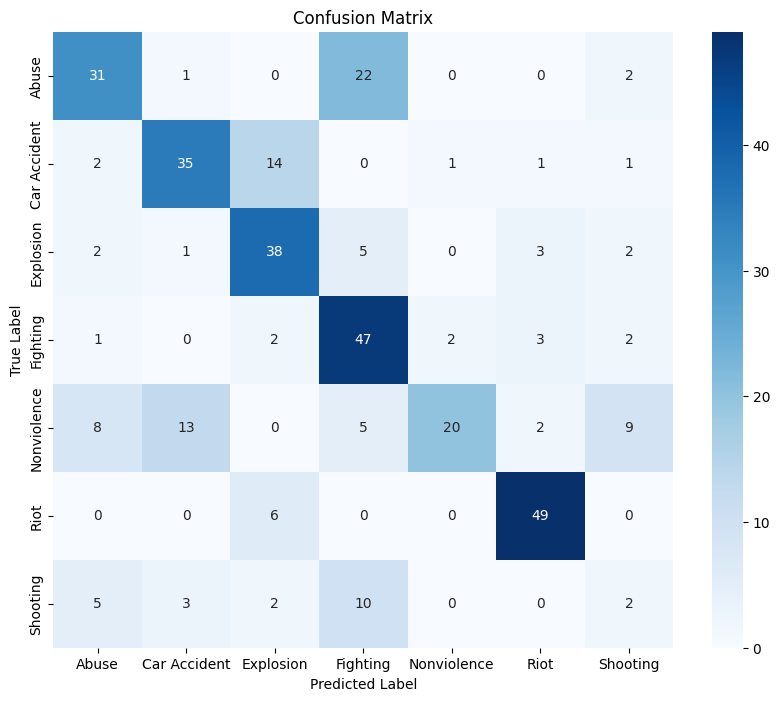

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

%matplotlib inline

eval_batch_size=32

eval_df = upsampled_test_df.groupby(upsampled_test_df.columns[1]).apply(lambda x: x.sample(50)).reset_index(drop=True)

# Display the new DataFrame
print(f"Eval df size {len(eval_df)}")
print(eval_df.sample(10))

eval_gen = VideoFrameGenerator(eval_df,batch_size=eval_batch_size,
                                max_frames=max_frames,image_size=(IMG_size,IMG_size,3),
                                shuffel=True, augmentation=False)


# Convert the VideoFrameGenerator objects to TensorFlow Datasets
output_signature = (tf.TensorSpec(shape = (None, max_frames, IMG_size, IMG_size, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (None,num_classes), dtype = tf.int16))


eval_dataset = tf.data.Dataset.from_generator(lambda: eval_gen,
                                         output_signature = output_signature)

def plot_confusion_matrix(model, data_loader, class_names):
    # Get the true labels and predictions
    y_true = []
    y_pred = []

    count=0
    for frames, labels in data_loader:
        print(f"count {count}")
        if count>len(eval_df)//eval_batch_size:
          break
        count+=1
        preds = model.predict(frames)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))


    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming 'vid_model' is your trained model and 'data_loader' is your data loader
# Assuming you have a list of class names
class_names = ['Abuse', 'Car Accident', 'Explosion', 'Fighting', 'Nonviolence', 'Riot', 'Shooting']

# Example usage
plot_confusion_matrix(loaded_model, eval_gen, class_names)